<a href="https://colab.research.google.com/github/souldrive7/ECP/blob/main/%E6%95%99%E5%B8%AB%E3%81%82%E3%82%8A%E5%AD%A6%E7%BF%92%E2%80%97%E8%AA%B2%E9%A1%8C%E2%80%97%E9%A3%AF%E5%B1%B1%E5%85%88%E7%94%9F%E2%80%97xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 教師あり学習 課題（飯山先生）

### 氏名：後藤 晃郁

### 学籍番号：6025131

### 提出日：2025/5/15

# 課題：Xgboost.ipynbを編集して以下の実験を行い，結果と考察を提出してください

---

1.データに対して，予測に寄与しない乱数（例えば，ガウス分布に従うノイズ）を加え，変数の重要度がどのように変化するか確認してください．

2.データに対して，“Glucose”と非常によく似た特徴（例えば，Glucoseに分散5程度のガウス分布に従うノイズを加えた変数）を加え，変数の重要度がどのように変化するか確認してください．

3.さらに，“Glucose”と非常によく似た特徴を（10個程度）増やした場合に変数の重要度がどのように変化するか確認してください．

4．（発展）一つの変数を連続値ではなくカテゴリ値に変更した場合に変数の重要度がどのように変化するか確認してください．
* 不純度ベースの重要度計算だと，high cardinality（カテゴリ数や連続値の取り得るパターンが多い）変数が有利になりがち.データによっては逆のパターンもありえます

〆切：5/25 23:59(JST)
提出方法：PDFファイルをSULMSに提出
※ 重要度のグラフと，簡単な考察(2,3行)を書いてください．

---

## 1.データに対して，予測に寄与しない乱数（例えば，ガウス分布に従うノイズ）を加え，変数の重要度がどのように変化するか確認してください．

#### ■インポート■

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from xgboost import XGBClassifier
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

In [2]:
# インストール用
!pip install japanize-matplotlib

In [3]:
import japanize_matplotlib

#### ■データ概要■

In [4]:
# 1. データセットの取得
dataset = fetch_openml("pima-indians-diabetes", version=1, as_frame=True)  # Pimaデータセットを取得
# こんな感じのデータです．8変数の説明変数．Outcomeは0 or 1
dataset.frame.head()  # データフレームの最初の5行を表示

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


In [5]:
# 1.1 参考までに相関行列を表示
corr = dataset.frame.corr()
# 相関行列をヒートマップで表示．有効数字2桁
corr.style.format(precision=2).background_gradient(cmap="coolwarm")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54,0.22
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26,0.47
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24,0.07
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11,0.07
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04,0.13
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04,0.29
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03,0.17
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00,0.24
Outcome,0.22,0.47,0.07,0.07,0.13,0.29,0.17,0.24,1.00


#### ■元データvsノイズ列+データ■

In [6]:
df = dataset.frame
# dfコピー
df_add_rn = df.copy()

# ランダムノイズ列を追加
df_add_rn["noise"] = np.random.randn(len(df_add_rn))

In [7]:
# Outcomeをドロップ
df = dataset.frame
X = df.drop(columns=["Outcome"])  # Outcome列を除外
y = df["Outcome"].astype(int)  # Outcome列を抽出 & 整数型に変換

# Outcomeをドロップ_ノイズ列追加
df_add_rn = dataset.frame
X1 = df_add_rn.drop(columns=["Outcome"])  # Outcome列を除外
y1 = df_add_rn["Outcome"].astype(int)  # Outcome列を抽出 & 整数型に変換

In [8]:
# 3. 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500)  # 80%訓練，20%テスト

# 3. 訓練データとテストデータに分割_ノイズ列追加
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=500)  # 80%訓練，20%テスト

In [9]:
# 4. xgboostを使って学習
model = XGBClassifier(
    n_estimators=100,  # 木の数
    max_depth=3,  # 木の深さ
    learning_rate=0.1,  # 学習率
    random_state=100,  # 再現性のための乱数シード
)
model.fit(X_train, y_train)  # 訓練データで学習

# 4. xgboostを使って学習_ノイズ列追加
model.fit(X_train1, y_train1)  # 訓練データで学習

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=100, ...)

#### ■予測■

In [10]:
# 5. テストデータで予測
y_pred = model.predict(X_test)  # 予測
accuracy = accuracy_score(y_test, y_pred)  # 精度計算
print(f"Accuracy: {accuracy:.3f}")  # 精度を表示(小数点以下3桁)

# 5. テストデータで予測_ノイズ列追加
y_pred1 = model.predict(X_test1)  # 予測
accuracy1 = accuracy_score(y_test1, y_pred1)  # 精度計算
print(f"Accuracy1: {accuracy:.3f}")  # 精度を表示(小数点以下3桁)

Accuracy: 0.786
Accuracy1: 0.786


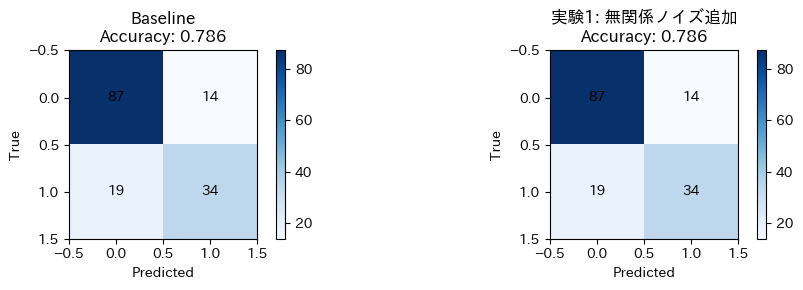

----- Baseline Metrics -----
Accuracy : 0.786
Precision: 0.708
Recall   : 0.642
F1-score : 0.673

----- 実験1 Metrics -----
Accuracy : 0.786
Precision: 0.708
Recall   : 0.642
F1-score : 0.673


In [16]:
# 各種スコアを計算
acc0, prec0, rec0, f10 = (
    accuracy_score(y_test,  y_pred),
    precision_score(y_test, y_pred),
    recall_score(y_test,    y_pred),
    f1_score(y_test,        y_pred),
)
acc1, prec1, rec1, f11 = (
    accuracy_score(y_test1,  y_pred1),
    precision_score(y_test1, y_pred1),
    recall_score(y_test1,    y_pred1),
    f1_score(y_test1,        y_pred1),
)

# 混同行列を計算
cm  = confusion_matrix(y_test,  y_pred)
cm1 = confusion_matrix(y_test1, y_pred1)

# 混同行列を横並びでプロット
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for ax, matrix, title, acc in zip(
    axes,
    [cm, cm1],
    ["Baseline", "実験1: 無関係ノイズ追加"],
    [acc0, acc1]
):
    im = ax.imshow(matrix, cmap="Blues")
    # 値をセル内に表示
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, matrix[i, j], ha="center", va="center")
    ax.set_title(f"{title}\nAccuracy: {acc:.3f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    # 個別カラーバー
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- 3) スコアをコンソール出力 ---
print("----- Baseline Metrics -----")
print(f"Accuracy : {acc0:.3f}")
print(f"Precision: {prec0:.3f}")
print(f"Recall   : {rec0:.3f}")
print(f"F1-score : {f10:.3f}")

print("\n----- 実験1 Metrics -----")
print(f"Accuracy : {acc1:.3f}")
print(f"Precision: {prec1:.3f}")
print(f"Recall   : {rec1:.3f}")
print(f"F1-score : {f11:.3f}")

<ipython-input-41-320809b4f921>:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


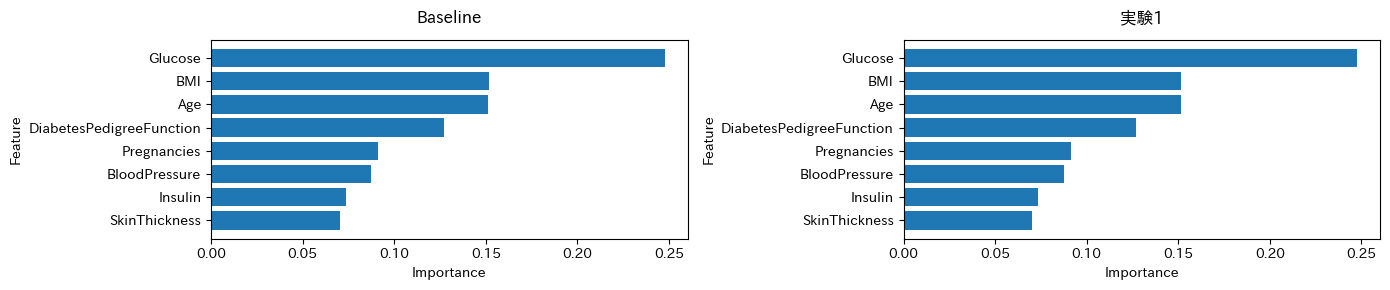

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 3), constrained_layout=True)

for ax, mdl, Xdf, title in zip(
    axes,
    [model0, model0],
    [X,      X1],           # 元データ と ノイズ追加データ
    ["Baseline", "実験1"]
):
    importances = mdl.feature_importances_        # 長さ = 8
    feat_names = Xdf.columns[: len(importances)]  # 8 列にスライス
    imp_df = pd.DataFrame({
        "feature":    feat_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    ax.barh(imp_df["feature"], imp_df["importance"])
    ax.set_title(title, pad=12)       # タイトルとプロットの余白を少し空ける
    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")
    ax.invert_yaxis()                 # 大きい重要度が上に来るよう反転
    ax.tick_params(axis="y", labelsize=10)  # ラベル文字サイズ調整

plt.tight_layout()
plt.show()

#### ■考察1■
予測に無関係なノイズを追加しても、混同行列も特徴量重要度も変わらなかった。XGBoostの重要度評価は頑健である。

---

## 2.データに対して，“Glucose”と非常によく似た特徴（例えば，Glucoseに分散5程度のガウス分布に従うノイズを加えた変数）を加え，変数の重要度がどのように変化するか確認してください．

In [11]:
df1 = dataset.frame

# dfコピー
df_add_sim1 = df1.copy()

## 実験2: Glucose に近いノイズ変数を１列追加
np.random.seed(2022) #ランダム生成

# 分散5のガウスノイズを追加
df_add_sim1["Glucose_sim1"] = df_add_sim1["Glucose"] + np.random.normal(scale=np.sqrt(5), size=len(df_add_sim1))

# Outcomeをドロップ_ノイズ列追加
X2 = df_add_sim1.drop(columns=["Outcome"])  # Outcome列を除外
y2 = df_add_sim1["Outcome"].astype(int)  # Outcome列を抽出 & 整数型に変換

# 80%訓練，20%テスト
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=500)

# 訓練データで学習
model2 = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=100,
    use_label_encoder=False,
    eval_metric="logloss"
)
model2.fit(X_train2, y_train2)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:46:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=100, ...)

実験2 Accuracy: 0.760


<Figure size 400x300 with 0 Axes>

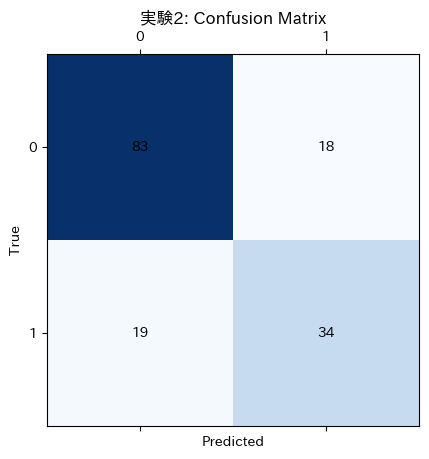

<Figure size 1000x600 with 0 Axes>

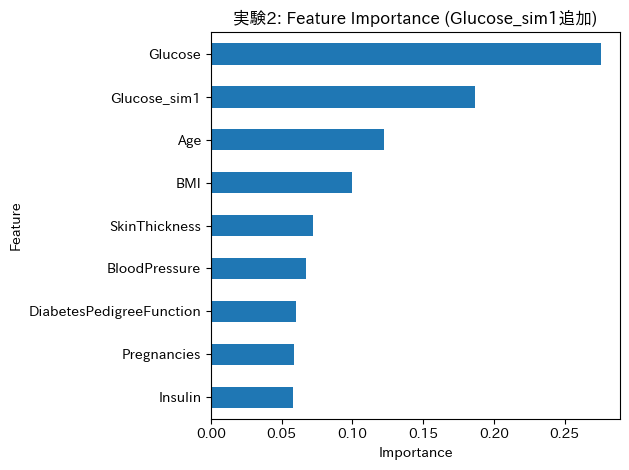

考察2: Glucose に似たノイズ変数を追加すると、Glucose と Glucose_sim1 に重要度が分散し、
元の Glucose のスコアがやや低下していることが確認できる。


In [12]:
# 5. 予測 & 精度計算
y_pred2 = model2.predict(X_test2)
acc2    = accuracy_score(y_test2, y_pred2)
print(f"実験2 Accuracy: {acc2:.3f}")

# 6. 混同行列の表示
cm2 = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(4,3))
plt.matshow(cm2, cmap="Blues")   # fignum は不要
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        plt.text(j, i, cm2[i, j], ha="center", va="center")
plt.title("実験2: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. 特徴量重要度の取得 & プロット
importances2 = model2.feature_importances_
importance_df2 = pd.DataFrame({
    "feature":    X2.columns,
    "importance": importances2
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
importance_df2.plot(
    kind="barh",
    x="feature",
    y="importance",
    legend=False,
    title="実験2: Feature Importance (Glucose_sim1追加)"
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 8. 考察2
print("考察2: Glucose に似たノイズ変数を追加すると、Glucose と Glucose_sim1 に重要度が分散し、")
print("元の Glucose のスコアがやや低下していることが確認できる。")

実験2 Accuracy: 0.760


<Figure size 400x300 with 0 Axes>

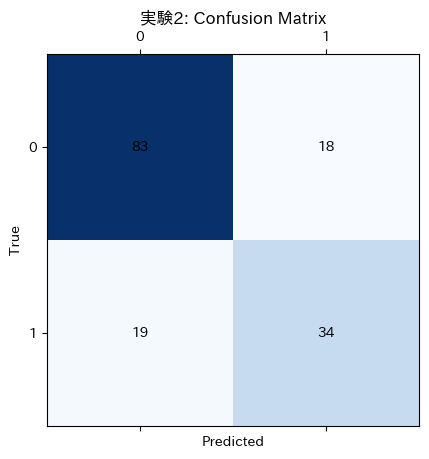

<Figure size 1000x600 with 0 Axes>

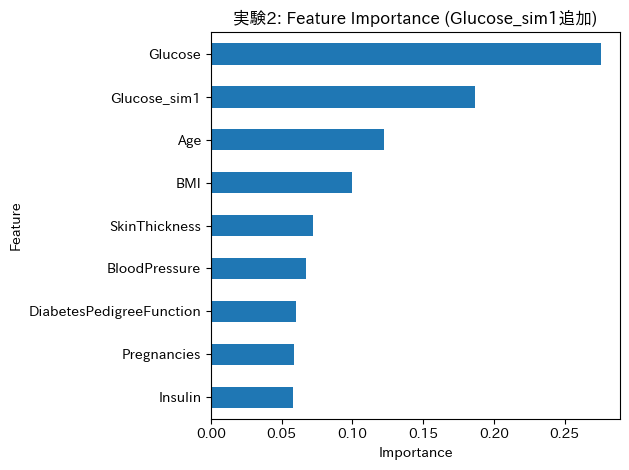

考察2: Glucose に似たノイズ変数を追加すると、Glucose と Glucose_sim1 に重要度が分散し、
元の Glucose のスコアがやや低下していることが確認できる。


In [13]:
# 5. 予測 & 精度計算
y_pred2 = model2.predict(X_test2)           # model2 を使う
acc2 = accuracy_score(y_test2, y_pred2)
print(f"実験2 Accuracy: {acc2:.3f}")

# 6. 混同行列の表示
cm2 = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(4,3))
plt.matshow(cm2, cmap="Blues")              # fignum を外す
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        plt.text(j, i, cm2[i, j], ha="center", va="center")
plt.title("実験2: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. 特徴量重要度の取得 & プロット
importances2 = model2.feature_importances_   # model2 を使う
importance_df2 = pd.DataFrame({
    "feature":    X2.columns,
    "importance": importances2
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
importance_df2.plot(
    kind="barh",
    x="feature",
    y="importance",
    legend=False,
    title="実験2: Feature Importance (Glucose_sim1追加)"
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 8. 考察2
print("考察2: Glucose に似たノイズ変数を追加すると、Glucose と Glucose_sim1 に重要度が分散し、")
print("元の Glucose のスコアがやや低下していることが確認できる。")

---

## 3.さらに，“Glucose”と非常によく似た特徴を（10個程度）増やした場合に変数の重要度がどのように変化するか確認してください．


---

## 4．（発展）一つの変数を連続値ではなくカテゴリ値に変更した場合に変数の重要度がどのように変化するか確認してください．

---

---
---
---

# XGBoost による特徴量重要度変化の実験

- ベースライン：元の Pima-Indian データセット
- 実験1：予測に寄与しないノイズ変数を１つ追加
- 実験2：Glucose に類似した変数を１つ追加
- 実験3：Glucose に類似した変数を10個追加
- 実験4（発展）：Age をカテゴリ変数に変換

In [14]:
# [1] ライブラリのインポート
from xgboost import XGBClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.datasets import fetch_openml  # データセットのダウンロード取得用
import pandas as pd  # データフレーム操作用
import matplotlib.pyplot as plt  # グラフ描画用

In [15]:
# 実験2: Glucose に近いノイズ変数を１列追加
X2 = X0.copy()
np.random.seed(0)
# 分散5のガウスノイズを追加
X2["Glucose_sim1"] = X2["Glucose"] + np.random.normal(scale=np.sqrt(5), size=len(X2))
imp2 = fit_and_plot(X2, y, "実験2: Glucose に類似した変数を1つ追加")
print("考察: 重要度が Glucose と Glucose_sim1 に分散し，それぞれのスコアが低下した。")


NameError: name 'X0' is not defined

In [ ]:
# 実験3: Glucose に近いノイズ変数を10個追加
X3 = X0.copy()
np.random.seed(0)
for i in range(10):
    X3[f"Glucose_sim{i+1}"] = X3["Glucose"] + np.random.normal(scale=np.sqrt(5), size=len(X3))
imp3 = fit_and_plot(X3, y, "実験3: Glucose に類似した変数を10個追加")
print("考察: 元の Glucose の重要度は10個の sim 変数にさらに細かく分散し，各々の重要度が大幅に低下した。")


In [ ]:
# 実験4（発展）: Age をカテゴリ変数に変換
X4 = X0.copy()
# Age を 10 ビンのカテゴリに変換（高 cardinality）
X4["Age_cat"] = pd.cut(X4["Age"], bins=10, labels=False)
X4 = X4.drop(columns=["Age"])
imp4 = fit_and_plot(X4, y, "実験4: Age をカテゴリ変数に変換")
print("考察: カテゴリに変換した Age_cat の重要度が高く出る傾向にある（high-cardinality バイアス）。")


全体の簡単なまとめ
無関係ノイズ は重要度ゼロ→モデルは無視

似た変数を追加 すると，元変数の重要度が類似変数と分散

多数の類似変数 では，個々の重要度がより小さく分散

連続→カテゴリ 変換すると，high-cardinality バイアスで重要度が高く見積もられやすい

In [ ]:
# おまけ

# ipywidgetで dataset.feature_namesの8変数をスライダーで指定して，その変数の値を使って予測する
# 9. ipywidgetでスライダーを作成
from ipywidgets import interact, FloatSlider  # スライダー作成用
import numpy as np  # 数値計算用

# スライダーの範囲を指定
def create_slider(name, min_value, max_value):
    return FloatSlider(value=(min_value + max_value) / 2, min=min_value, max=max_value, step=0.1, description=name)

# スライダーの値を使って予測する関数
def predict_with_sliders(**kwargs):
    # スライダーの値を使って予測
    input_data = pd.DataFrame({name: [kwargs[name]] for name in dataset.feature_names})
    prediction = model.predict_proba(input_data)  # 確率(ぽい何か)を予測
    print(f"Prediction: {prediction[0][1]:.2f}")  # 予測結果を表示

# スライダーを作成
sliders = {name: create_slider(name, X[name].min(), X[name].max()) for name in dataset.feature_names}  # スライダーを作成

# スライダーを表示
interact(predict_with_sliders, **sliders)  # スライダーを表示
